In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm

import sys
sys.path.append('D:\diplom_2\my_test')
import my_funcs as mf

import my_thermal_funcs as mtf

## STENCIL-NET

In [2]:
# import torch
# import torch.nn as nn

# from torch.optim import Adam
# from torch.optim.lr_scheduler import ExponentialLR
# from stencilnet import MLPConv, forward_rk3_error, backward_rk3_error,backward_rk3_tvd_error,forward_rk3_tvd_error
# from stencilnet import forward_rk1_error,backward_rk1_error
# from utils import load_simulation_model

##### 0. Mesh Params

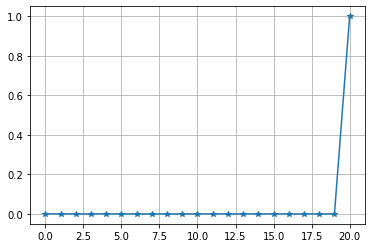

In [3]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных
# generate_flg=False

n=21 #число узлов
L=1 # длина расчт области
T=.3 #конечное время
kurant=0.5

h=L/(n-1)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
# IC
v=[0 for i in range(0,n)]
# v=[np.sin(6.6*np.pi*i/n) for i in range(0,n)] #sin(6.6x)
# BC
v[0]=0
v[-1]=1

plt.plot(v,'-*')
plt.grid()

##### 1. Study params

In [13]:
main_params=pd.read_excel('init_params.xlsx')
main_params=main_params.set_index('param')
display(main_params)

#------------------------MAIN PARAMS-----------------------------
# size of filter to be applied
fs = int(main_params.loc['fs'])

# number of timesteps to be predicted during training 
m = int(main_params.loc['m'])

# decaying weights
decay_const = float(main_params.loc['decay_const'])

# epoch_number
epochs=int(main_params.loc['epochs'])

#random_seed
seed = int(main_params.loc['seed'])

#coef для loss функции
l_wd= float(main_params.loc['l_wd'])

# 'RK3' for runge-kutta solver and 'E1' for euler solver
method=str(main_params.loc['method'].values[0]) 

#neurons num in MLPConv
neurons=int(main_params.loc['neurons'])

#learning_rate
lr=float(main_params.loc['lr'])

#train_size
train_split=float(main_params.loc['train_split'])

# on/off bwd
has_backward=bool(main_params.loc['has_backward'].values[0])

#hidden_layers_num
hidden_layers_num=int(main_params.loc['hidden_layers_num'])

#device
device = mf.torch.device("cuda" if mf.torch.cuda.is_available() else "cpu")

#optuna n_trials
N_TRIALS=int(main_params.loc['N_TRIALS'])

,value
param,
seed,1
method,RK3
decay_const,0.9
train_split,0.7
m,4
epochs,100
l_wd,0.0
fs,3
neurons,64


##### 2.1 Generate data

In [5]:
CUSTOM_TAU=kurant*h**2#0.009
# CUSTOM_TAU=0.01
v_fact,x_lst,tau,time_lst=mtf.generate_data(generate_flg,v,T,L,0.5,h,n,CUSTOM_TAU=CUSTOM_TAU,save_flg=True)
print(v_fact.shape)

Генерация данных
242 21
21 242
(21, 242)


##### 2.2 view dynamic of solution

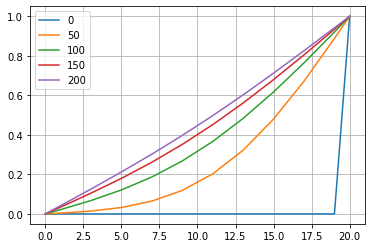

In [6]:
for j in range(0,len(v_fact[0,:]),50):
# for j in range(0,2,1):
    plt.plot(v_fact[:,j],label=str(j))
plt.legend()
plt.grid()

##### 3.Subsample Data

In [7]:
t_factor = 10  # time subsample factor 
s_factor = 4   # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=mf.subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (6, 25)
train (6, 17)
test (6, 8)


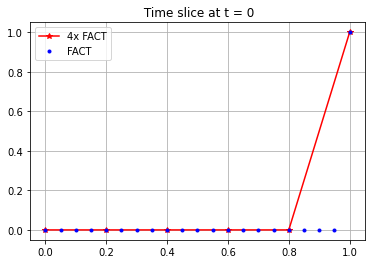

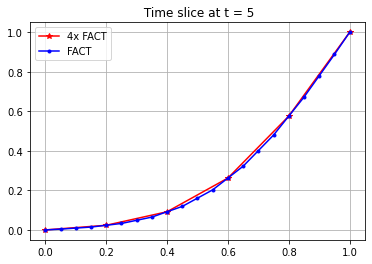

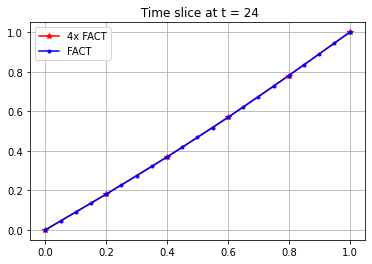

In [8]:
plt.figure()
time=0 #first time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t = 0")
plt.grid()
plt.show()

plt.figure()
time=5 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.-',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t = " + str(time))
plt.grid()
plt.show()

plt.figure()
time=v_coarse.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.-',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t = " + str(time))
plt.grid()
plt.show()


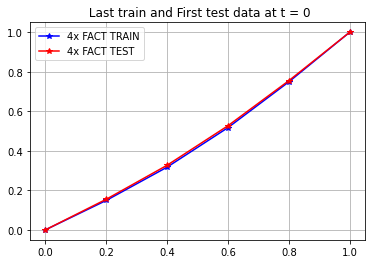

In [9]:
# Last train first test
plt.figure()
time=v_coarse_train.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse_train[:,time],'*-',color='blue',label=str(s_factor) + 'x FACT TRAIN')
time=0
plt.plot(x_lst[coarse_x],v_coarse_test[:,time],'*-',color='red',label=str(s_factor) + 'x FACT TEST')
plt.legend()
plt.title(" Last train and First test data at t = " + str(time))
plt.grid()
plt.show()

##### 4. Trainig model

In [10]:
import optuna

In [14]:
def objective_mplconv(trial):
    my_doc_params={
    'fs' : trial.suggest_categorical('fs',[1,3,5,9]),   
    'neurons' : trial.suggest_categorical('neurons',[16,32,64]) ,
    'hidden_layers_num': trial.suggest_categorical('hidden_layers_num',[0,1,2,3,4]),
    'lr': trial.suggest_categorical('lr',[1e-02,1e-03]),
    'm' : trial.suggest_categorical('m',[2,4,6]) ,  
    'has_backward' : trial.suggest_categorical('has_backward',[True,False])   
    }
    
    metric=mf.train_net(mf.MLPConv,v_coarse_train,mf.epochs,dtc,
                        **my_doc_params)[2]
    return metric

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_mplconv, n_trials=N_TRIALS)

[I 2024-10-27 16:56:07,563] A new study created in memory with name: no-name-668ed83c-769b-4b4e-a92d-941164db2753


input 3 output 64
input 64 output 64
input 64 output 1
#parameters: 4481


100%|██████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.80it/s, loss=7.12e-5]
[I 2024-10-27 16:56:11,043] Trial 0 finished with value: 7.123949762899429e-05 and parameters: {'fs': 3, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}. Best is trial 0 with value: 7.123949762899429e-05.


input 3 output 16
input 16 output 16
input 16 output 16
input 16 output 1
#parameters: 625


100%|██████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.21it/s, loss=0.00226]
[I 2024-10-27 16:56:12,782] Trial 1 finished with value: 0.0022624232806265354 and parameters: {'fs': 3, 'neurons': 16, 'hidden_layers_num': 3, 'lr': 0.001, 'm': 2, 'has_backward': False}. Best is trial 0 with value: 7.123949762899429e-05.


input 3 output 32
input 32 output 32
input 32 output 1
#parameters: 1217


100%|██████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.65it/s, loss=0.00407]
[I 2024-10-27 16:56:14,502] Trial 2 finished with value: 0.004072190728038549 and parameters: {'fs': 3, 'neurons': 32, 'hidden_layers_num': 2, 'lr': 0.001, 'm': 2, 'has_backward': True}. Best is trial 0 with value: 7.123949762899429e-05.


In [16]:
study.trials_dataframe()
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'fs': 3, 'neurons': 64, 'hidden_layers_num': 2, 'lr': 0.01, 'm': 2, 'has_backward': False}
Best RMSE: 7.123949762899429e-05


In [17]:
my_doc_params=study.best_params
net,loss_lst,loss=mf.train_net(mf.MLPConv,v_coarse_train,mf.epochs,dtc,
                               **my_doc_params)

input 3 output 64
input 64 output 64
input 64 output 1
#parameters: 4481


100%|██████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.09it/s, loss=7.12e-5]


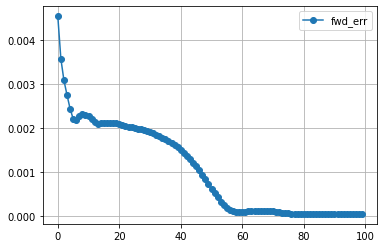

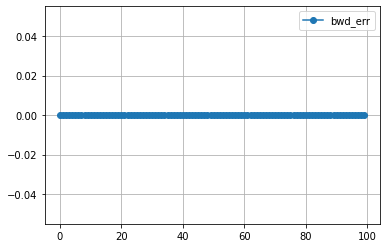

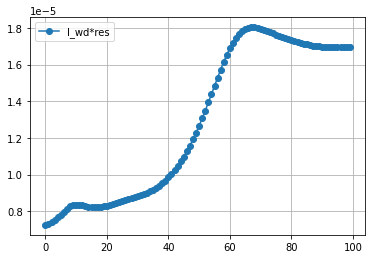

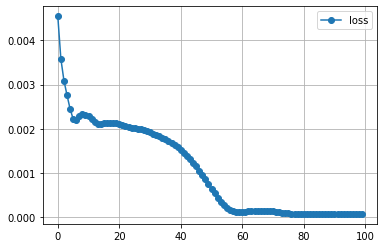

In [18]:
mf.plot_err_and_components_of_err(np.array(loss_lst))

##### 4/2. Re-fit on higher epoch_num 

In [19]:
high_epochs=1000
my_doc_params=study.best_params
my_doc_params.update({'epoch':high_epochs})
display(mf.make_param_table(net,my_doc_params,tau,h,n,t_factor,s_factor))

,Parameter,Value
0,fs,3
1,neurons,64
2,hidden_layers_num,2
3,act_func,ELU(alpha=1.0)
4,epoch,1000
5,lr,0.01
6,tau,0.00125
7,h,0.05
8,n,21
9,decay_const,0.9


In [20]:
my_doc_params

{'fs': 3,
 'neurons': 64,
 'hidden_layers_num': 2,
 'lr': 0.01,
 'm': 2,
 'has_backward': False,
 'epoch': 1000}

In [21]:
del my_doc_params['epoch']
net,loss_lst,loss=mf.train_net(mf.MLPConv,v_coarse_train,high_epochs,dtc,**my_doc_params)

input 3 output 64
input 64 output 64
input 64 output 1
#parameters: 4481


100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.56it/s, loss=2.29e-5]


##### 5. save_model

In [ ]:
# str(list(my_doc_params))

In [ ]:
# save model
# torch.save(net, './data/models/model_thermal_n=' +str(n)+'_'+ str(list(my_doc_params.values())) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

In [ ]:
# save study history
# study.trials_dataframe().to_excel(fr'data/models/trials_dataframe_n=' +str(n)+'_'+ str(list(my_doc_params.values()))+'.xlsx',index=False)

In [ ]:
# save hyperparams
# my_doc_params['fs']=[my_doc_params['fs']]
# pd.DataFrame.from_dict(my_doc_params,dtype=str)

In [ ]:
# pd.DataFrame.from_dict(my_doc_params,dtype=str).to_excel(fr'data/models/best_params_n=' +str(n)+'_'+str(list(my_doc_params.values()))+'.xlsx',index=False)

##### 6. load_model

In [ ]:
# neurons = 64
# fs=7
# epochs=100
# m=4
# l_wd=0#1e-3
# seed=1
#method='E1'

# net = load_simulation_model(s_factor, t_factor, neurons, device)

# net=torch.load('./models/model_thermal_n=' +str(n)+'_' + str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

##### 7. Simulation

In [22]:
NN_sim,T_sim,x_sim=mf.make_simulation(net,v_coarse,L,Lxc,dtc)

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 344.16it/s]


##### 8. view_results

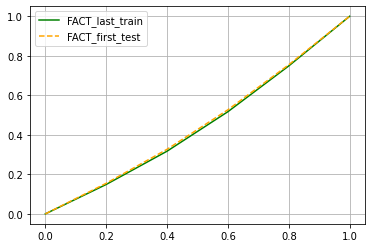

In [23]:
mf.view_train_test_graph(x_sim,v_coarse_train,v_coarse_test)

In [24]:
# todo
my_doc_params.update({'epoch':high_epochs})
display(mf.make_param_table(net,my_doc_params,tau,h,n,t_factor,s_factor))

,Parameter,Value
0,fs,3
1,neurons,64
2,hidden_layers_num,2
3,act_func,ELU(alpha=1.0)
4,epoch,1000
5,lr,0.01
6,tau,0.00125
7,h,0.05
8,n,21
9,decay_const,0.9


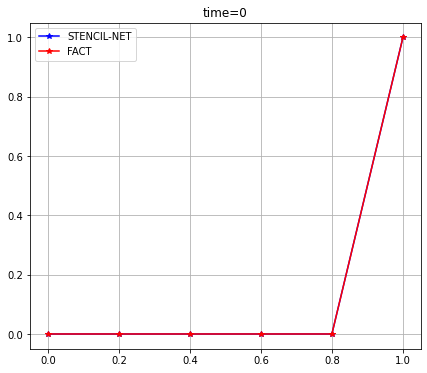

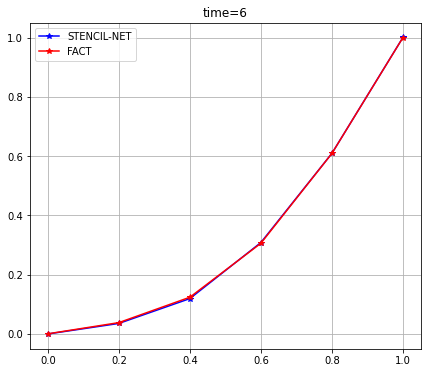

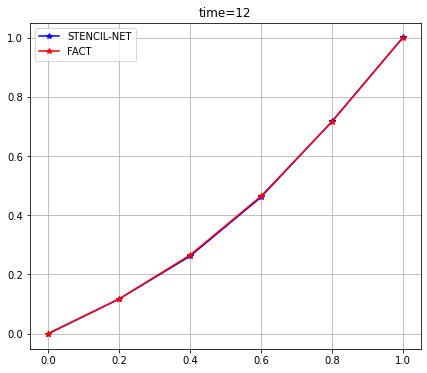

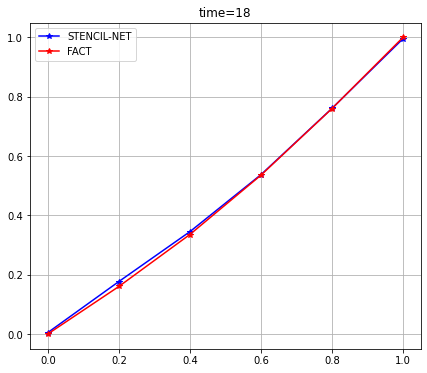

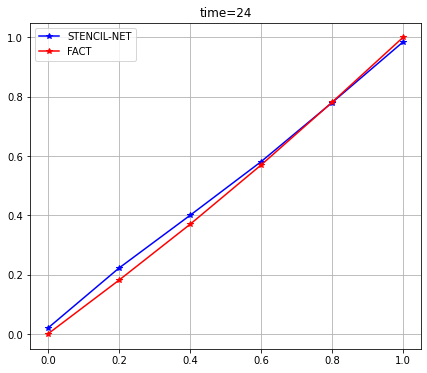

In [25]:
mf.view_results(T_sim,x_sim,NN_sim,v_coarse)

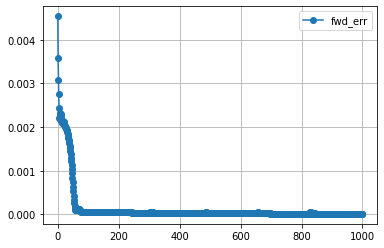

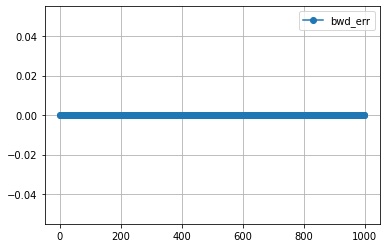

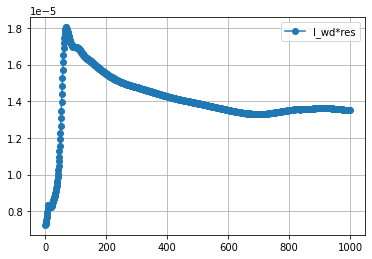

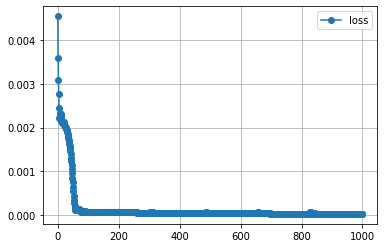

In [26]:
mf.plot_err_and_components_of_err(np.array(loss_lst))